# Trabalho 1: Resolução de Equações Não Lineares
## Disciplina: Cálculo Numérico
**Aluno:** Emanuel Antônio Rocha
**Data:** 28/11/2025

---

### 1. Introdução e Contextualização do Problema

**O Problema do Fator de Atrito em Tubulações (Engenharia)**

Na engenharia, o transporte de fluidos é fundamental. Para dimensionar bombas e tubulações, é preciso calcular a perda de energia devido ao atrito do fluido com as paredes do tubo.

O parâmetro central para esse cálculo é o **Fator de Atrito de Darcy ($f$)**. Para escoamentos turbulentos, a relação entre esse fator, o número de Reynolds ($Re$) e a rugosidade relativa do tubo ($\varepsilon/D$) é dada pela **Equação de Colebrook-White**:

$$\frac{1}{\sqrt{f}} = -2 \log_{10} \left( \frac{\varepsilon/D}{3.7} + \frac{2.51}{Re \sqrt{f}} \right)$$

**Por que usar Métodos Numéricos?**
Esta é uma equação **implícita e não linear**. Observe que a variável $f$ aparece nos dois lados da igualdade (dentro da raiz e dentro do logaritmo). É matematicamente impossível isolar $f$ analiticamente. Portanto, o uso de métodos numéricos para encontrar a raiz da função é obrigatório para resolver esse problema do mundo real.

O número de Reynolds (Re) representa a razão entre forças inerciais e viscosas do fluido, enquanto a rugosidade relativa (ε/D) expressa o quanto a parede da tubulação afeta o escoamento. Ambos influenciam diretamente o fator de atrito.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Configuração do Estilo dos Gráficos ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- Dados do Problema (Parâmetros de Entrada) ---
# Vamos simular um fluxo de água em um tubo de aço comercial
Re = 100000.0       # Número de Reynolds (adimensional) - Fluxo turbulento
rugosidade = 0.001  # Rugosidade relativa (epsilon/D)

print(f"Parâmetros definidos:\nReynolds (Re): {Re}\nRugosidade Relativa (e/D): {rugosidade}")

Parâmetros definidos:
Reynolds (Re): 100000.0
Rugosidade Relativa (e/D): 0.001


### 2. Definição da Função $g(f) = 0$

Para aplicar os métodos de busca de raízes (zeros de função), precisamos reescrever a equação de Colebrook na forma $g(f) = 0$. Movemos todos os termos para um lado da igualdade:

$$g(f) = \frac{1}{\sqrt{f}} + 2 \log_{10} \left( \frac{\varepsilon/D}{3.7} + \frac{2.51}{Re \sqrt{f}} \right) = 0$$

Abaixo, implementamos esta função e sua derivada (necessária para o método de Newton-Raphson).

In [18]:
def colebrook_function(f, Re, rug):
    """
    Função g(f) da equação de Colebrook-White.
    Queremos encontrar f tal que esta função retorne 0.
    """
    # Evitar divisão por zero ou raiz negativa
    if f <= 0:
        return np.inf
    
    term1 = 1.0 / np.sqrt(f)
    term2 = 2.0 * np.log10((rug / 3.7) + (2.51 / (Re * np.sqrt(f))))
    return term1 + term2

def colebrook_derivative(f, Re, rug):
    """
    Derivada g'(f) da função de Colebrook.
    Necessária para o método de Newton-Raphson.
    Calculada via regra da cadeia.
    """
    # Derivada de 1/sqrt(f) -> -0.5 * f^(-1.5)
    term1_deriv = -0.5 * np.power(f, -1.5)
    
    # Derivada do termo logarítmico (Regra da cadeia)
    # d/df [2 * log10(u)] = 2 * (1 / (u * ln(10))) * u'
    
    u = (rug / 3.7) + (2.51 / (Re * np.sqrt(f)))
    du_df = (2.51 / Re) * (-0.5 * np.power(f, -1.5))
    
    term2_deriv = 2.0 * (1.0 / (u * np.log(10))) * du_df
    
    return term1_deriv + term2_deriv

### 3. Implementação dos Métodos Numéricos

Nesta seção, implementamos três métodos clássicos para comparação:

1.  **Método da Bisseção:** Requer um intervalo $[a, b]$ onde a função muda de sinal. É robusto, mas tem convergência lenta (linear).
2.  **Método de Newton-Raphson:** Requer um chute inicial $x_0$ e a derivada da função. Possui convergência quadrática (muito rápida) próximo à raiz.
3.  **Método da Secante:** Similar ao Newton, mas aproxima a derivada usando dois pontos iniciais ($x_0, x_1$). Útil quando a derivada é difícil de calcular.

In [19]:
# --- 1. Método da Bisseção ---
def metodo_bissecao(a, b, Re, rug, tol=1e-7, max_iter=100):
    dados = []
    
    # Verifica mudança de sinal
    if colebrook_function(a, Re, rug) * colebrook_function(b, Re, rug) >= 0:
        print("Erro: A função não muda de sinal no intervalo fornecido.")
        return None, []

    for i in range(max_iter):
        c = (a + b) / 2.0
        f_c = colebrook_function(c, Re, rug)
        
        dados.append({'Iter': i+1, 'Metodo': 'Bisseção', 'f (Raiz)': c, 'Erro': abs(f_c)})
        
        if abs(f_c) < tol:
            return c, dados
        
        if colebrook_function(a, Re, rug) * f_c < 0:
            b = c
        else:
            a = c
            
    return c, dados

# --- 2. Método de Newton-Raphson ---
def metodo_newton(x0, Re, rug, tol=1e-7, max_iter=100):
    dados = []
    x = x0
    
    for i in range(max_iter):
        fx = colebrook_function(x, Re, rug)
        dfx = colebrook_derivative(x, Re, rug)
        
        if dfx == 0:
            print("Derivada zero. Método falhou.")
            break
            
        x_new = x - (fx / dfx)
        dados.append({'Iter': i+1, 'Metodo': 'Newton', 'f (Raiz)': x_new, 'Erro': abs(fx)})
        
        if abs(x_new - x) < tol:
            return x_new, dados
        if abs(fx) < tol:
            return x_new, dados
        
        x = x_new
    return x, dados

# --- 3. Método da Secante ---
def metodo_secante(x0, x1, Re, rug, tol=1e-7, max_iter=100):
    dados = []
    
    for i in range(max_iter):
        fx0 = colebrook_function(x0, Re, rug)
        fx1 = colebrook_function(x1, Re, rug)
        
        if (fx1 - fx0) == 0:
            print("Divisão por zero no método da Secante.")
            break
            
        x2 = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        erro = abs(colebrook_function(x2, Re, rug))
        dados.append({'Iter': i+1, 'Metodo': 'Secante', 'f (Raiz)': x2, 'Erro': erro})
        
        if abs(x2 - x1) < tol:
            return x2, dados
            
        x0 = x1
        x1 = x2
        
    return x1, dados

### 4. Execução e Análise dos Resultados

Abaixo, executamos os três métodos.
* **Intervalo para Bisseção:** [0.008, 0.08] (Valores físicos típicos para fator de atrito).
* **Chute para Newton:** 0.05.
* **Chutes para Secante:** 0.01 e 0.05.

In [25]:
# Executando os métodos
raiz_b, dados_b = metodo_bissecao(0.008, 0.08, Re, rugosidade)
raiz_n, dados_n = metodo_newton(0.05, Re, rugosidade)
raiz_s, dados_s = metodo_secante(0.01, 0.05, Re, rugosidade)

# Criando DataFrames para exibição
df_b = pd.DataFrame(dados_b)
df_n = pd.DataFrame(dados_n)
df_s = pd.DataFrame(dados_s)


df_resumo = pd.DataFrame({
    'Método': ['Bisseção', 'Newton-Raphson', 'Secante'],
    'Raiz encontrada': [raiz_b, raiz_n, raiz_s],
    'Iterações': [len(df_b), len(df_n), len(df_s)]
})

print(df_resumo)

           Método  Raiz encontrada  Iterações
0        Bisseção         0.022175         26
1  Newton-Raphson         0.022175         13
2         Secante         0.022175          8


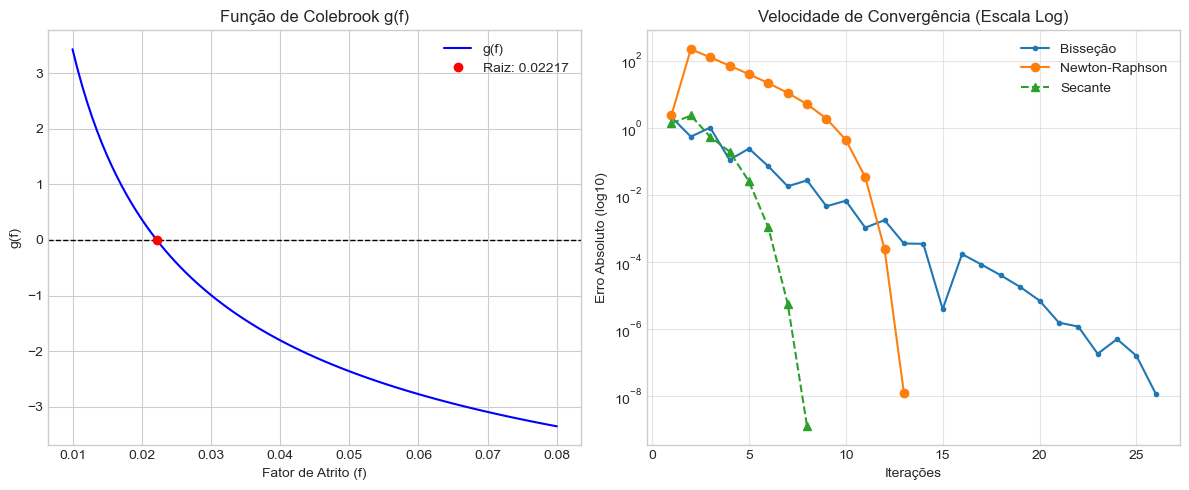

In [21]:
# --- Gráfico 1: Comportamento da Função e a Raiz ---
x_vals = np.linspace(0.01, 0.08, 100)
y_vals = [colebrook_function(x, Re, rugosidade) for x in x_vals]

plt.figure(figsize=(12, 5))

# Subplot 1: A Função
plt.subplot(1, 2, 1)
plt.plot(x_vals, y_vals, label='g(f)', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.plot(raiz_n, 0, 'ro', label=f'Raiz: {raiz_n:.5f}', zorder=5)
plt.title('Função de Colebrook g(f)')
plt.xlabel('Fator de Atrito (f)')
plt.ylabel('g(f)')
plt.legend()
plt.grid(True)

# Subplot 2: Comparação de Convergência (Erro)
plt.subplot(1, 2, 2)
plt.plot(df_b['Iter'], df_b['Erro'], label='Bisseção', marker='.', linestyle='-')
plt.plot(df_n['Iter'], df_n['Erro'], label='Newton-Raphson', marker='o', linestyle='-')
plt.plot(df_s['Iter'], df_s['Erro'], label='Secante', marker='^', linestyle='--')

plt.yscale('log') # Escala logarítmica é essencial aqui
plt.title('Velocidade de Convergência (Escala Log)')
plt.xlabel('Iterações')
plt.ylabel('Erro Absoluto (log10)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

### 5. Conclusão

Com base nos resultados obtidos e nos gráficos gerados, podemos concluir que:

1.  **Validação:** Todos os três métodos convergiram para a mesma raiz ($f \approx 0.022175$), confirmando a confiabilidade da solução numérica para a equação de Colebrook-White.

2.  **Análise de Desempenho:**
    * O **Método da Secante** apresentou o melhor desempenho neste cenário específico, convergindo em apenas **8 iterações**. Isso demonstra sua eficiência, especialmente considerando que ele não exige o cálculo analítico da derivada.
    * O **Método de Newton-Raphson**, apesar de ter convergência quadrática teórica, levou **13 iterações**. Observando o gráfico de convergência (linha laranja), nota-se que o erro aumentou nas primeiras iterações antes de cair drasticamente. Isso ocorre devido à sensibilidade do método ao "chute inicial" ($x_0$); um ponto inicial ligeiramente afastado pode causar oscilações antes da estabilização.
    * O **Método da Bisseção** confirmou seu comportamento teórico: é extremamente estável e garantido, porém possui convergência linear lenta, exigindo **26 iterações** (o triplo da Secante) para atingir a mesma precisão.

3.  **Considerações Finais:** Para aplicações de engenharia onde a derivada é complexa ou o ponto inicial é incerto, o Método da Secante mostrou-se uma alternativa robusta e eficiente frente ao clássico Newton-Raphson.

### 6. Referências

1. White, F. M. *Fluid Mechanics*. McGraw-Hill, 7ª edição.
2. Colebrook, C. F.; White, C. M. "The equation of turbulent flow in pipes." *Proceedings of the Royal Society of London*, 1937.
3. Ruggiero, Márcio; Lopes, Vera. *Cálculo Numérico*. Pearson.
4. Munson, Young & Okiishi. *Fundamentos da Mecânica dos Fluidos*. LTC.
5. Notas de aula da disciplina de Cálculo Numérico (IFMG).
